# Power Line Detection via Background Noise Removal

### Using a PowerLine Binary Classifier with MNIST Style

https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d

Adaptation du modèle de classificateur multiclasse de MNIST pour le classificateur binaire du PowerLine Detection 

In [1]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Prétraitement des données 

La procédure est un peu faite à la main pour éviter d'utiliser le keras preprocessing qui pourrait ne pas fonctionner. 

Les vecteurs x_train y_train etc sont justes des concaténations de tableaux numpy array ou entiers chargés depuis le dossier cropped. 
Ils sont ensuite mélangés avec la fonction shuffle. Même chose pour ce qui concerne les éléments y_test et x_test

C:\Users\VArri\Documents\PowerLines\images\visuel\cropped1000
(3185, 28, 28)
(3185,)
0


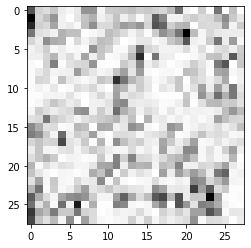

In [2]:
os.chdir(r"C:\Users\VArri\Documents\PowerLines\images\visuel\cropped1000")
path = os.getcwd()
print(path)

PL_path = os.path.join(path,'1')
noise_path = os.path.join(path,'0')
dirs_PL = os.listdir(PL_path)
dirs_noise = os.listdir(noise_path)

x_train = []
y_train = []

for pl in dirs_PL:
    x_train.append(cv2.imread(os.path.join(PL_path, pl), 0))
    y_train.append(1)
    
for noise in dirs_noise:
    x_train.append(cv2.imread(os.path.join(noise_path, noise), 0))
    y_train.append(0)

x_train = np.array(x_train).astype(np.uint8)
y_train = np.array(y_train).astype(np.uint8)

print(x_train.shape)
print(y_train.shape)

image_index = 2300 # You may select anything up to 60,000
print(y_train[image_index]) # The label is 8
plt.imshow(x_train[image_index], cmap='Greys')

C:\Users\VArri\Documents\PowerLines\images\visuel\cropped_test1000
(544, 28, 28)
(544,)
1


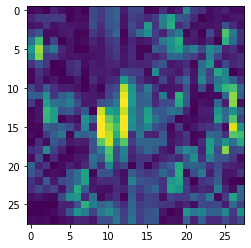

In [3]:
os.chdir(r"C:\Users\VArri\Documents\PowerLines\images\visuel\cropped_test1000")
path = os.getcwd()
print(path)

PL_path = os.path.join(path,'valid_1')
noise_path = os.path.join(path,'valid_0')
dirs_PL = os.listdir(PL_path)
dirs_noise = os.listdir(noise_path)

x_test = []
y_test = []

for pl in dirs_PL:
    x_test.append(cv2.imread(os.path.join(PL_path, pl), 0))
    y_test.append(1)
    
for noise in dirs_noise:
    x_test.append(cv2.imread(os.path.join(noise_path, noise), 0))
    y_test.append(0)

x_test = np.array(x_test).astype(np.uint8)
y_test = np.array(y_test).astype(np.uint8)

print(x_test.shape)
print(y_test.shape)

image_index = 200 # You may select anything up to 60,000
print(y_test[image_index]) # The label is 8
plt.imshow(x_test[image_index])

In [4]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = [28, 28, 1]
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (3185, 28, 28, 1)
Number of images in x_train 3185
Number of images in x_test 544


In [5]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_train, y_train)

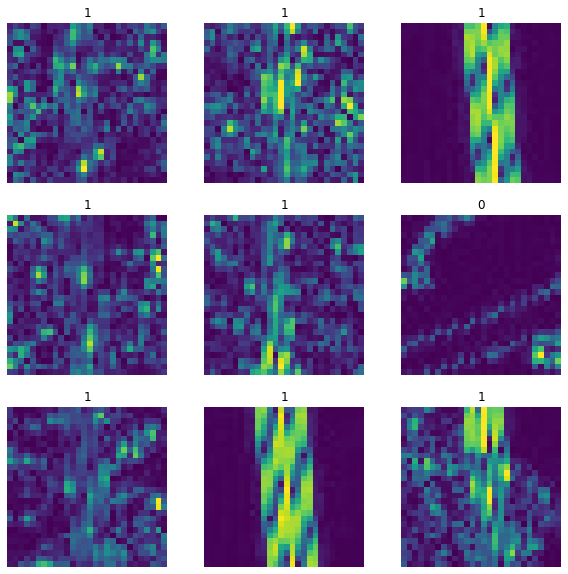

In [6]:
import matplotlib.pyplot as plt
from random import randrange
rank=randrange(0, x_train.shape[0])
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[rank+i])
    plt.title(y_train[rank+i])
    plt.axis("off")

## CNN Classifier

On utilise après calcul le CNN de l'article Pan 2016 pour différencier les pixels PL des non-PL. Etant donné la tâche binaire, on peut se contenter d'un seul neurone en sortie du CNN avec une activation 'sigmoid' pour effectuer la différenciation. La normalisation des données graphiques a déjà été réalisée en amont donc on peut se passer de ce layer. L'optimiseur est adapté au cas de la classification binaire avec 'binary_crossentropy'. On commence par effectuer seulement 5 epochs pour éviter l'overfitting. 

In [7]:
import tensorflow.keras as keras
model = keras.models.Sequential([
    # keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=[28,28,1]),
    keras.layers.Conv2D(6, kernel_size=5, strides=1, padding="valid", input_shape=input_shape),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(12, kernel_size=5, strides=1, padding="valid"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(192),
    keras.layers.Dense(1, activation="sigmoid")
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 12)          1812      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 12)          0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 192)               37056     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [9]:
epochs = 5

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(x=x_train,y=y_train, epochs=epochs, verbose=1,validation_split=0.25, shuffle=True)

Epoch 1/5
75/75 [==============================] - 2s 25ms/step - loss: 0.3544 - accuracy: 0.8526 - val_loss: 0.2488 - val_accuracy: 0.9059
Epoch 2/5
75/75 [==============================] - 1s 13ms/step - loss: 0.2210 - accuracy: 0.9104 - val_loss: 0.1677 - val_accuracy: 0.9410
Epoch 3/5
75/75 [==============================] - 1s 15ms/step - loss: 0.1475 - accuracy: 0.9485 - val_loss: 0.1270 - val_accuracy: 0.9486
Epoch 4/5
75/75 [==============================] - 1s 13ms/step - loss: 0.1127 - accuracy: 0.9627 - val_loss: 0.1197 - val_accuracy: 0.9511
Epoch 5/5
75/75 [==============================] - 1s 14ms/step - loss: 0.0930 - accuracy: 0.9724 - val_loss: 0.1046 - val_accuracy: 0.9636


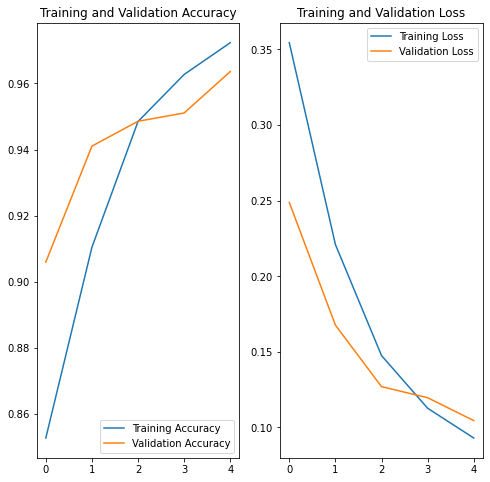

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
model.save('CNN/model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: CNN/model\assets


## Evaluation du modèle 

Ici on évalue la performance du modèle sur un jeu de données gardé à l'écart de l'entraînement. 

In [11]:
model.evaluate(x_test, y_test)

100/100 [==============================] - 1s 5ms/step - loss: 0.0761 - accuracy: 0.9739


[0.07608003169298172, 0.973940372467041]

In [12]:
pred = model.predict(x_test)

0


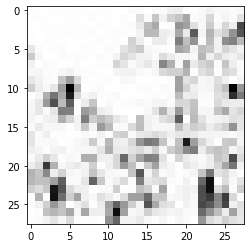

In [13]:
image_index = 797
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')

print(pred[image_index].argmax())

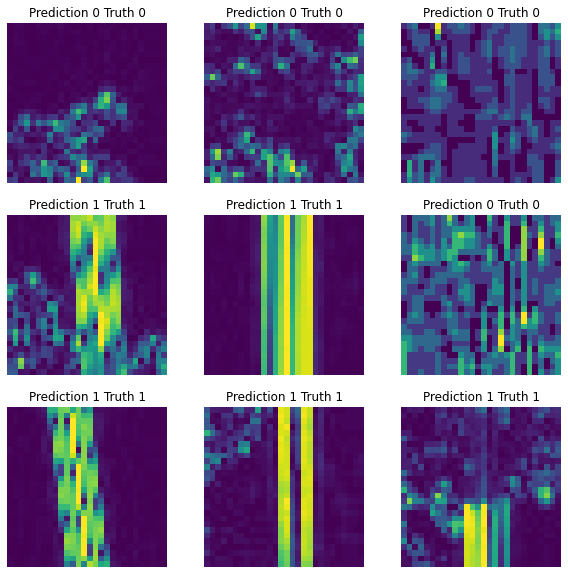

In [14]:
import matplotlib.pyplot as plt
from random import randrange

rank=randrange(0, x_test.shape[0])
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[rank+i])
    plt.title('Prediction {} Truth {}'.format(int(pred[rank+i].round()),y_test[rank+i]))
    plt.axis("off")

## Application du modèle au BACKGROUND NOISE REMOVAL sur une image entière

On fait glisser le classifier sur toute l'image et on stocke toutes les sorties dans un tableau de même dimension que l'on viendra superposer sur l'image de départ en post-traitement. 

Une question demeure
- Comment traiter les bords de l'image ?

In [15]:
os.chdir(r"C:\Users\VArri\Documents\PowerLines\images\visuel\steered1000")
path = os.getcwd()
print(path)

img_name = "20210507_133045_007_edge_steered.jpg"
img_path = os.path.join(path, img_name)
img = cv2.imread(img_path, 0)
img = img.astype('float32') /255

# img = img[:int(img.shape[0]/4), :]

img_shape = img.shape
detect = np.zeros(img_shape)

HT = int(28/2)


C:\Users\VArri\Documents\PowerLines\images\visuel\steered1000


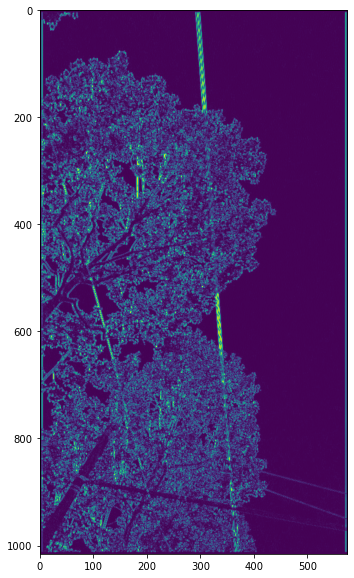

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()

In [17]:
img.shape

(1016, 575)

In [18]:
from tqdm import tqdm

cropped = []
for i in tqdm(range(HT, int((img.shape[0]-HT+1)))):
    for j in range(HT, img.shape[1]-HT+1):
        cropped.append(img[i-HT:i+HT, j-HT:j+HT])

cropped = np.array(cropped).astype(np.float32)
cropped = cropped.reshape([len(cropped), 28, 28, 1])
detect = model.predict(cropped).round()

tf.image.extract_patches

100%|██████████████████████████████████████████████████████████████████████████████| 989/989 [00:00<00:00, 1284.81it/s]


<function tensorflow.python.ops.array_ops.extract_image_patches_v2(images, sizes, strides, rates, padding, name=None)>

In [19]:
detect = detect.reshape(int((img.shape[0]-HT+1)) - HT, img.shape[1]-HT+1 - HT).astype(np.uint8)

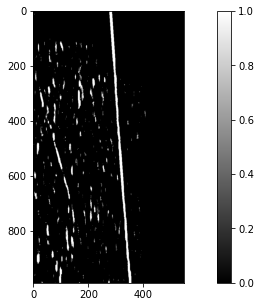

In [20]:
plt.figure(figsize=(12,5))
plt.imshow(detect, cmap='gray')
plt.colorbar()
plt.show()

## Reconstruction des lignes - Hough Transform 

detect must have integer values in it

(13, 1, 4)


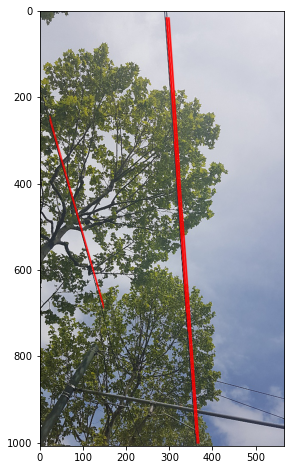

In [21]:
lines = cv2.HoughLinesP(image=detect, rho=1, theta=np.pi/180, threshold=50, lines=np.array([]),minLineLength=300, maxLineGap=50)

# Opencv
# rho : The resolution of the parameter r in pixels. FIXED
# theta: The resolution of the parameter θ in radians. FIXED
# threshold: The minimum number of intersections to "*detect*" a line
# minLineLength: The minimum number of points that can form a line. 
    # Lines with less than this number of points are disregarded.
# maxLineGap: The maximum gap between two points to be considered in the same line.

lst = img_name.split('_')
origin = '_'.join(lst[:-2]) + '_edge.jpg'
os.chdir('../edge1000')

img = cv2.imread(origin, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
a,b,c = lines.shape
print(lines.shape)
for i in range(a):
    l = lines[i][0]
    cv2.line(img, (l[0]+HT, l[1]+HT), (l[2]+HT, l[3]+HT), (255,0,0), 1, cv2.LINE_AA)
    # cv2.imwrite('houghlines4.jpg', img)
plt.figure(figsize=(16, 8)) 
plt.imshow(img)
plt.show()

In [23]:
print(os.getcwd())

C:\Users\VArri\Documents\PowerLines\images\visuel\edge1000


In [24]:
cv2.imwrite('test.jpg', img)

True